In [1]:
import torch.nn as nn
import torch
from learned_dict import TiedSAE
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from transformers import ViTForImageClassification, ViTImageProcessor
from util import ActivationDataset, plot_activation
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
from collections import Counter

/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-02-23 15:48:36.672013: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 15:48:36.672057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 15:48:36.674034: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 15:48:38.038888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model = 'nateraw/vit-base-patch16-224-cifar10'
model = ViTForImageClassification.from_pretrained(vit_model, output_hidden_states=True).to(device)

model.eval()
processor = ViTImageProcessor.from_pretrained(vit_model)
to_pil = transforms.ToPILImage()

/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


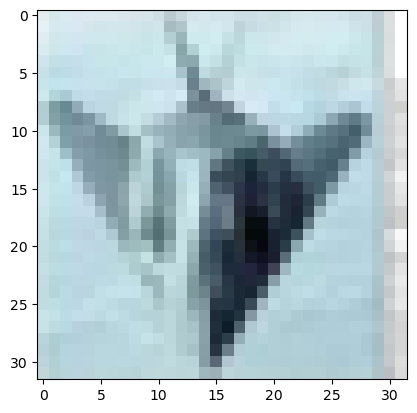

In [3]:
# Create a DataLoader
dataset = ActivationDataset('activations_cifar10_vit_b/cifar10_activations_0.h5','vit.encoder.layer.0.output')

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
input_image = next(iter(data_loader))[0][0]
plt.imshow(input_image.permute(1,2,0))
inputs = processor(images=to_pil(input_image), return_tensors="pt")

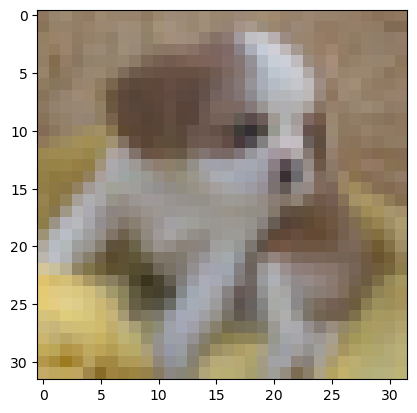

In [4]:
# Create a DataLoader2
dataset2 = ActivationDataset('activations_cifar10_vit_b/cifar10_activations_5.h5','vit.encoder.layer.0.output')

data_loader2 = DataLoader(dataset2, batch_size=32, shuffle=True)

input_image2 = next(iter(data_loader2))[0][0]
plt.imshow(input_image2.permute(1,2,0))

inputs2 = processor(images=to_pil(input_image2), return_tensors="pt")

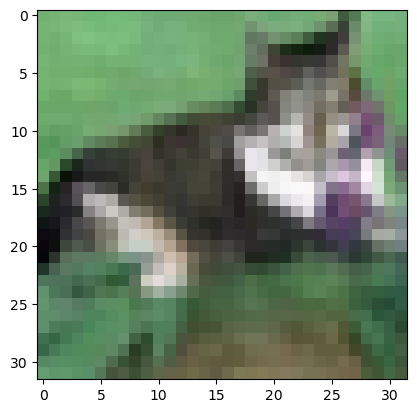

In [5]:
# Create a DataLoader
dataset3 = ActivationDataset('activations_cifar10_vit_b/cifar10_activations_3.h5','vit.encoder.layer.0.output')

data_loader3 = DataLoader(dataset3, batch_size=32, shuffle=True)

input_image3 = next(iter(data_loader3))[0][0]
plt.imshow(input_image3.permute(1,2,0))

inputs3 = processor(images=to_pil(input_image3), return_tensors="pt")

# Look into individual features activated with x10 model

layer 0


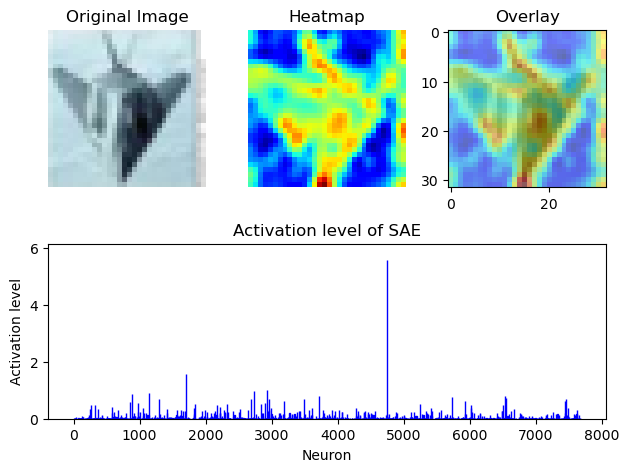

layer 1


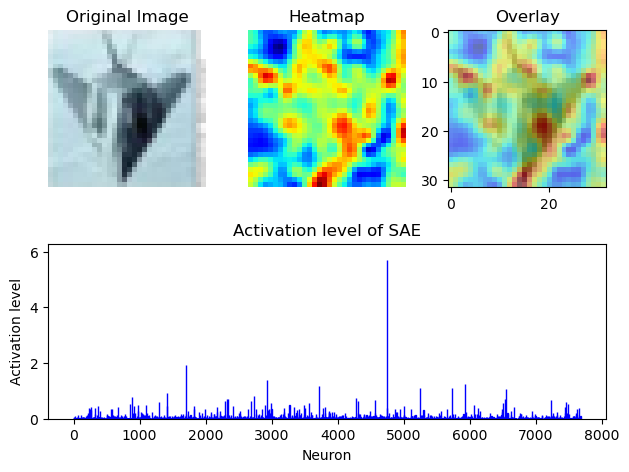

layer 2


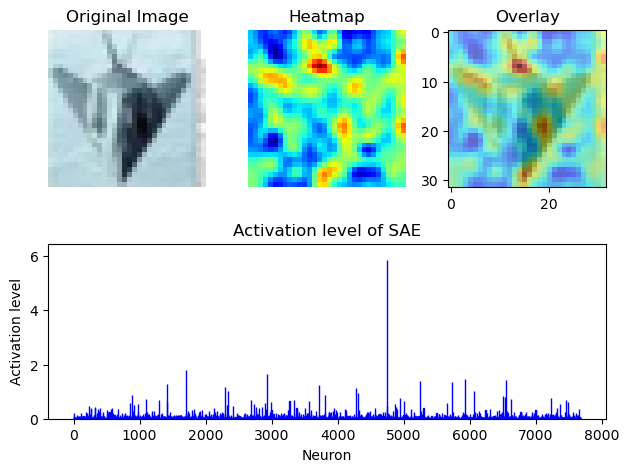

layer 3


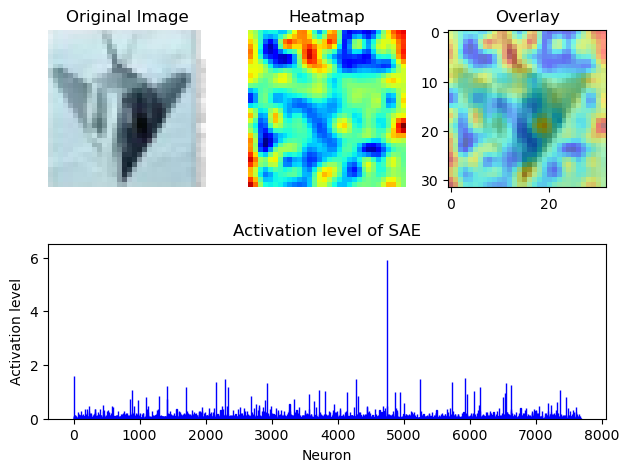

layer 4


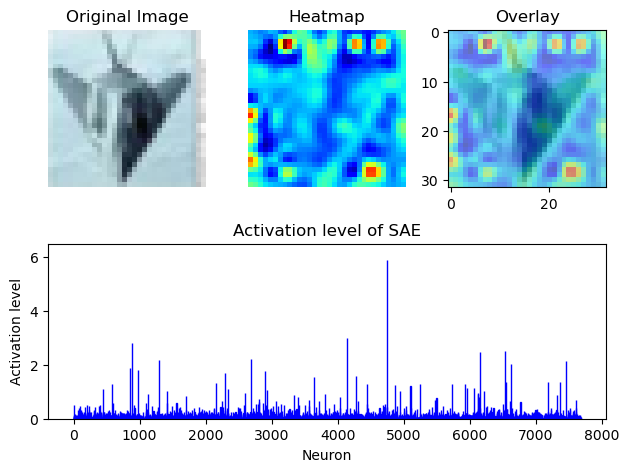

layer 5


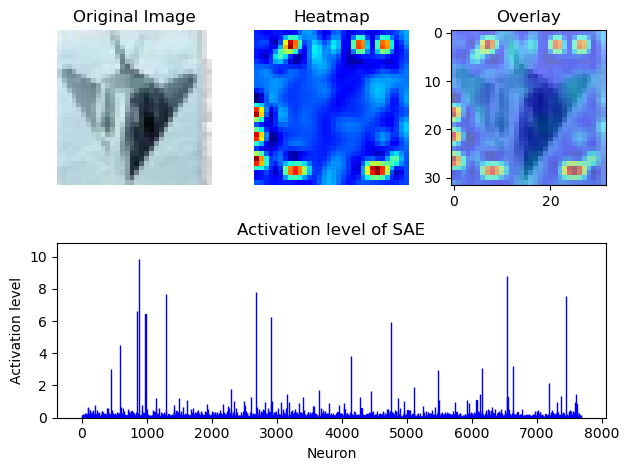

layer 6


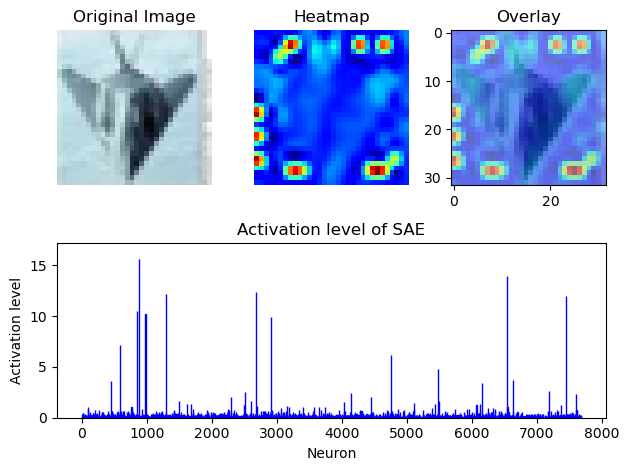

layer 7


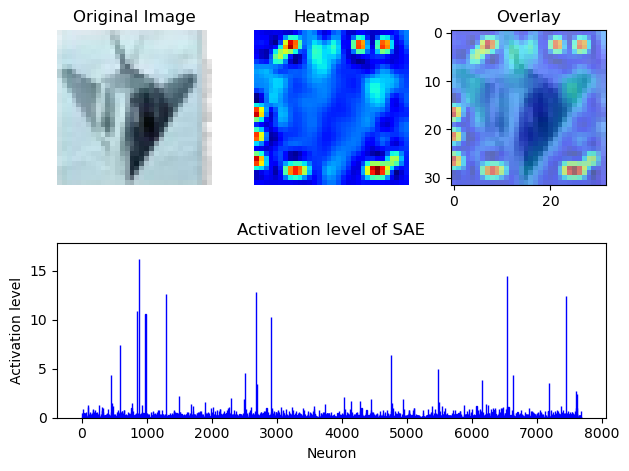

layer 8


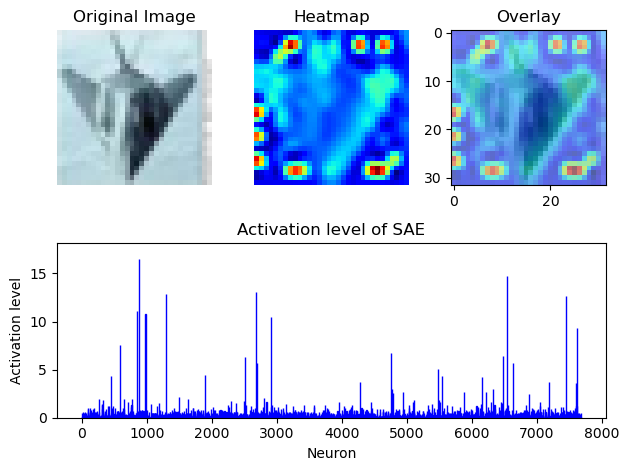

layer 9


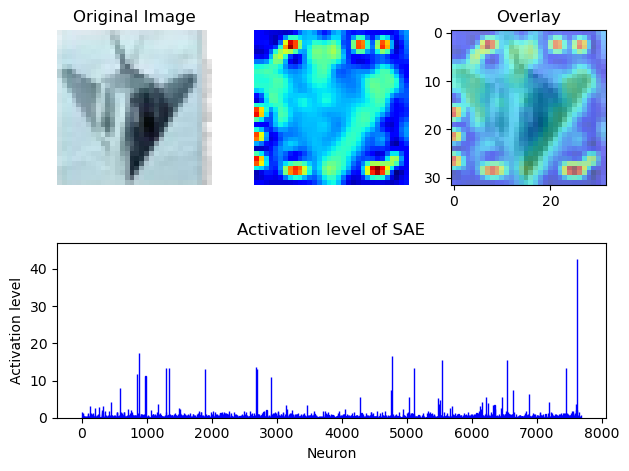

layer 10


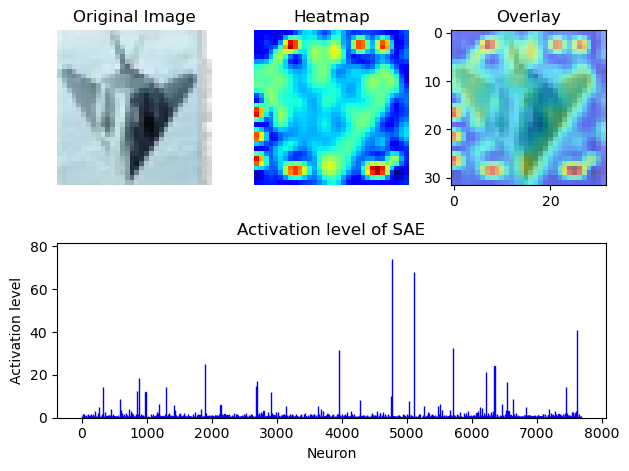

layer 11


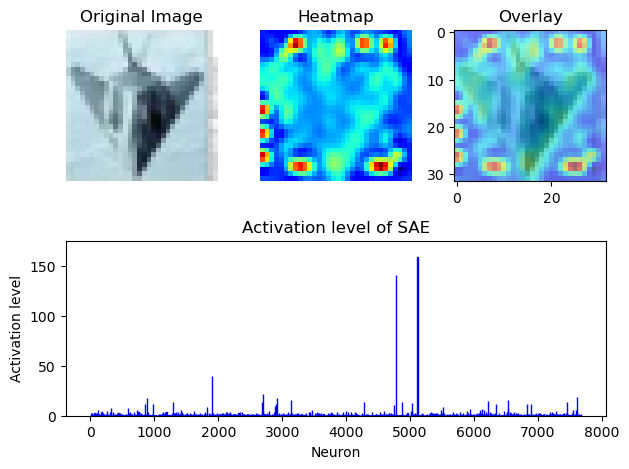

layer 0


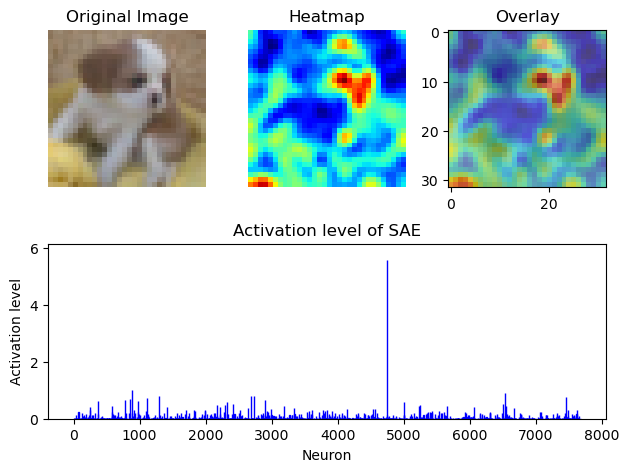

layer 1


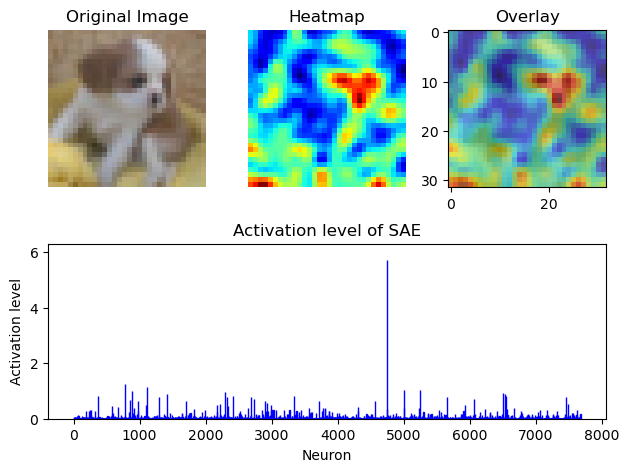

layer 2


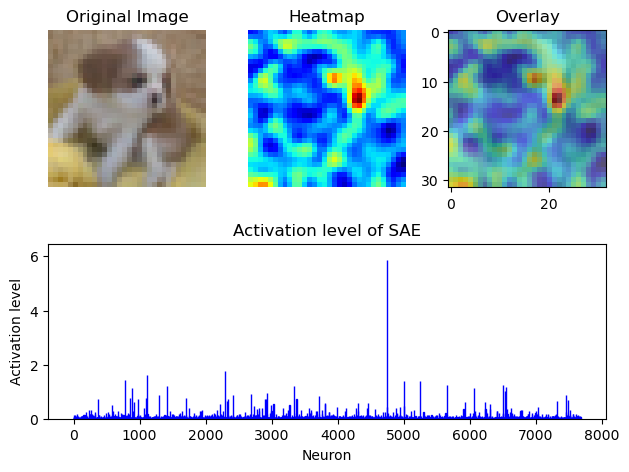

layer 3


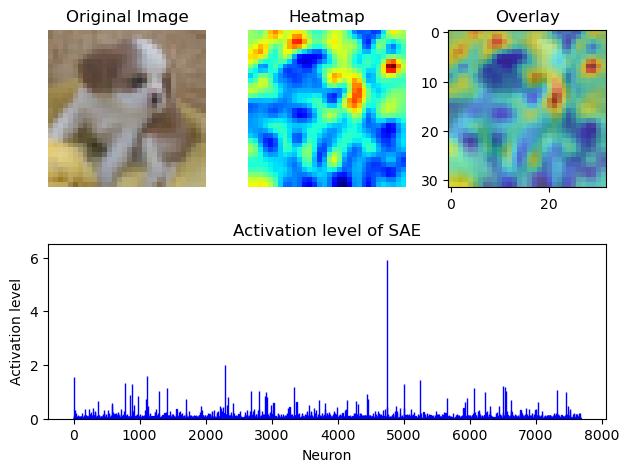

layer 4


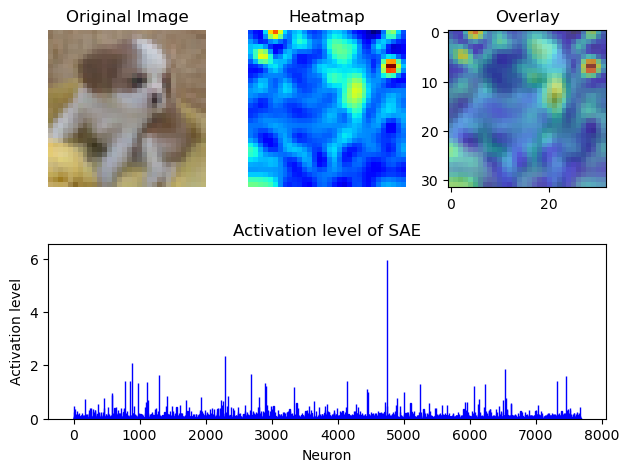

layer 5


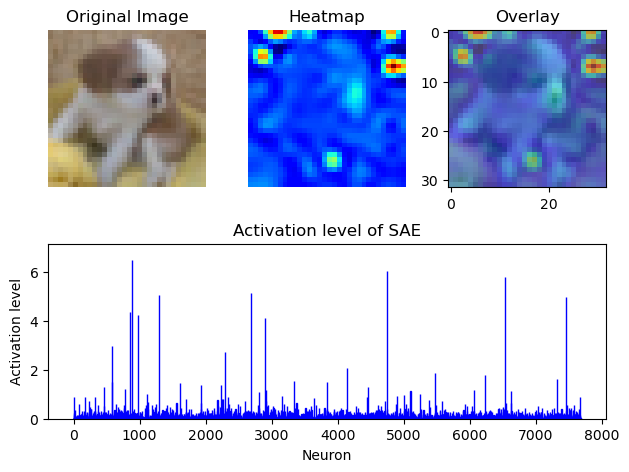

layer 6


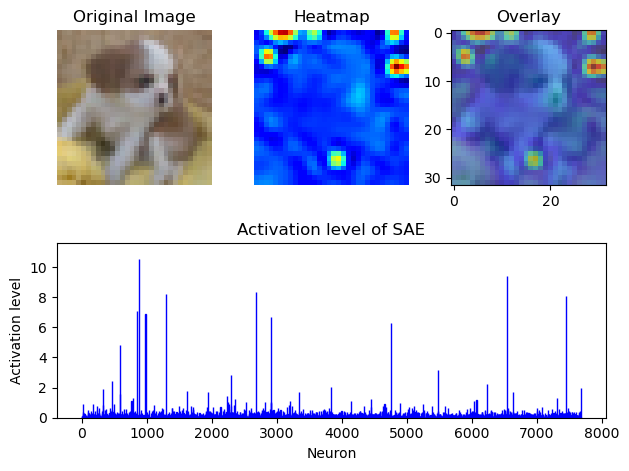

layer 7


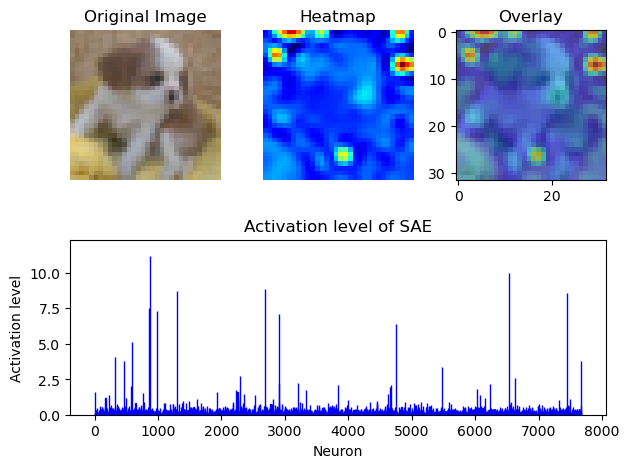

layer 8


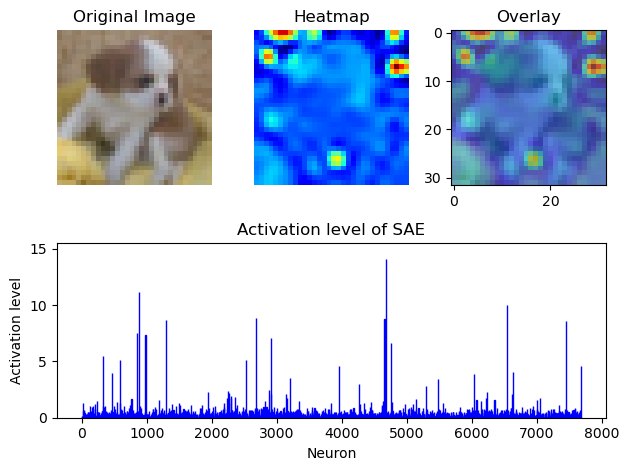

layer 9


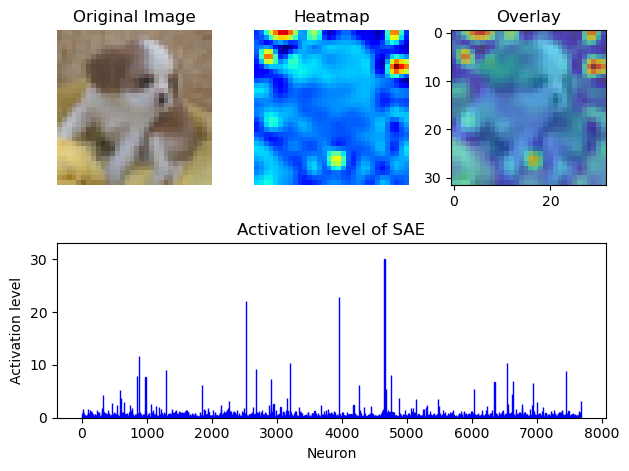

layer 10


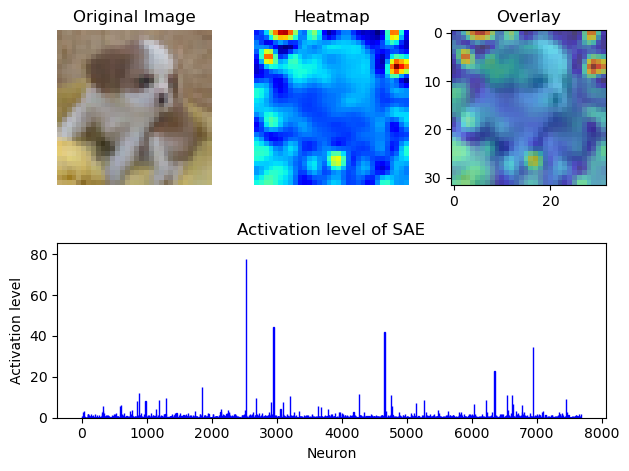

layer 11


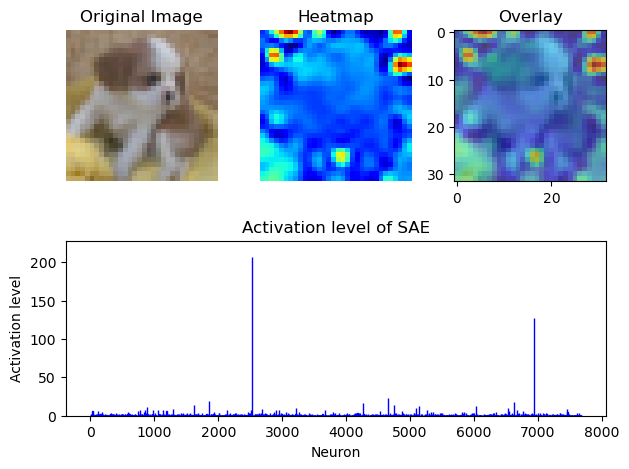

layer 0


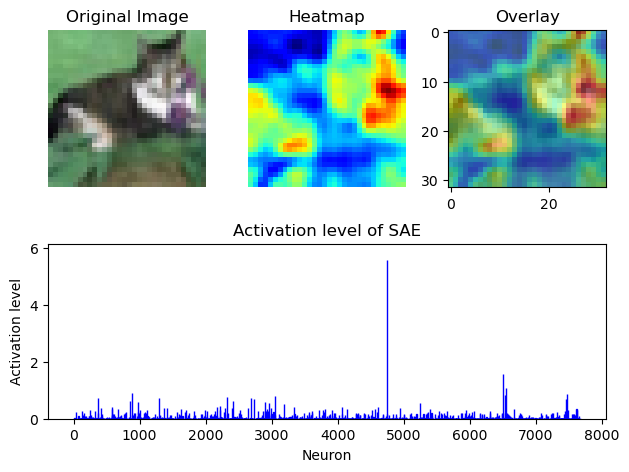

layer 1


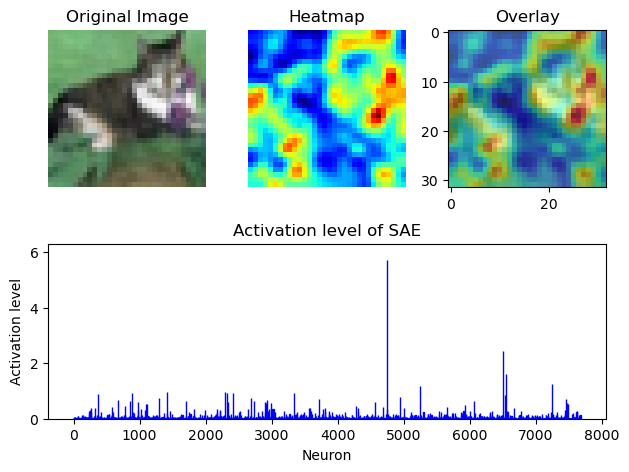

layer 2


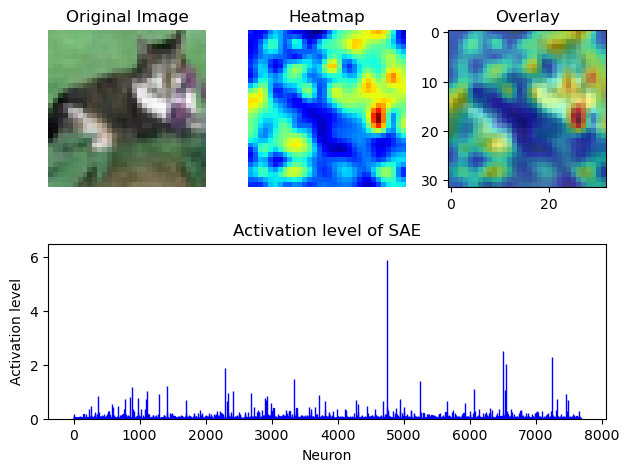

layer 3


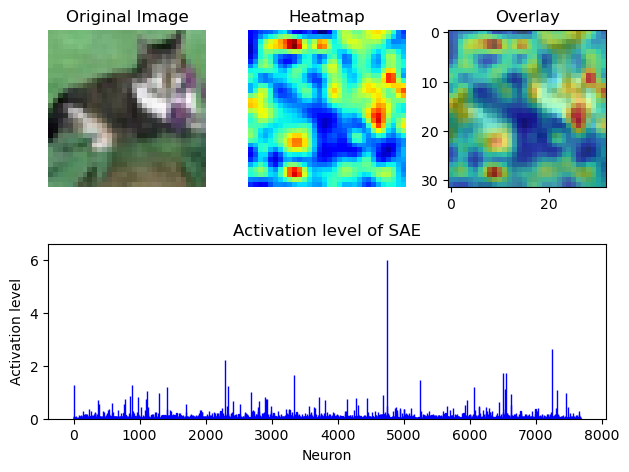

layer 4


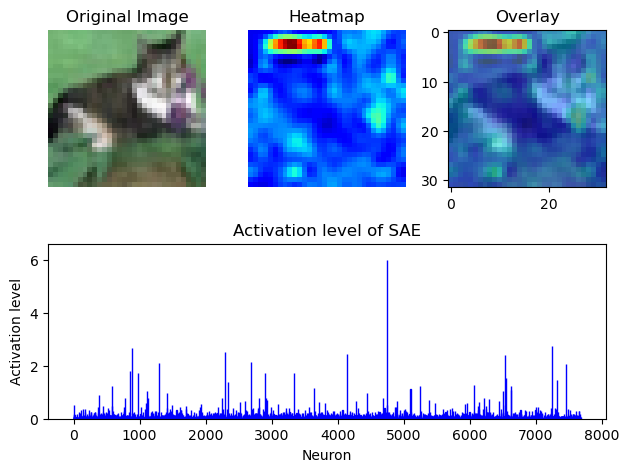

layer 5


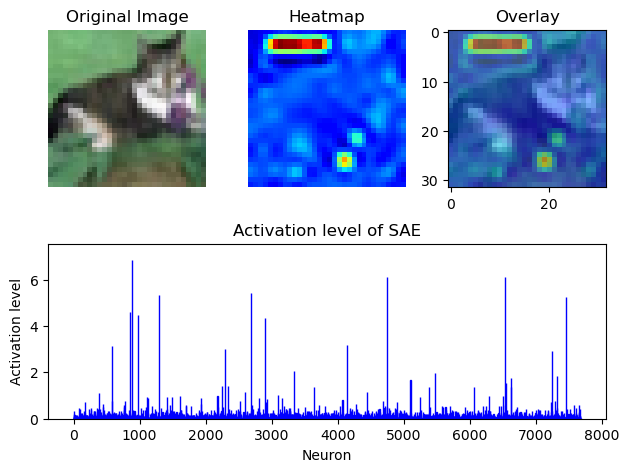

layer 6


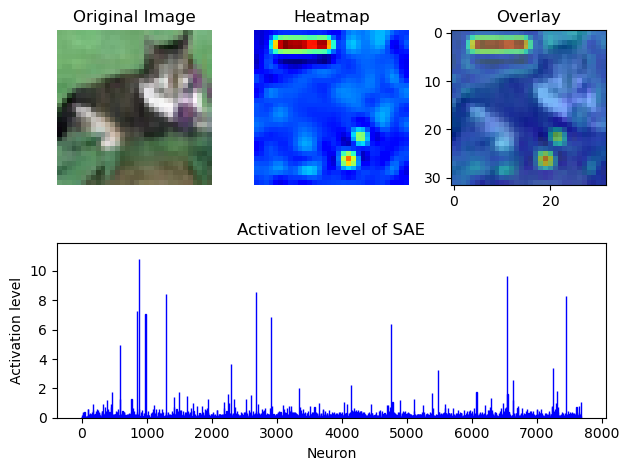

layer 7


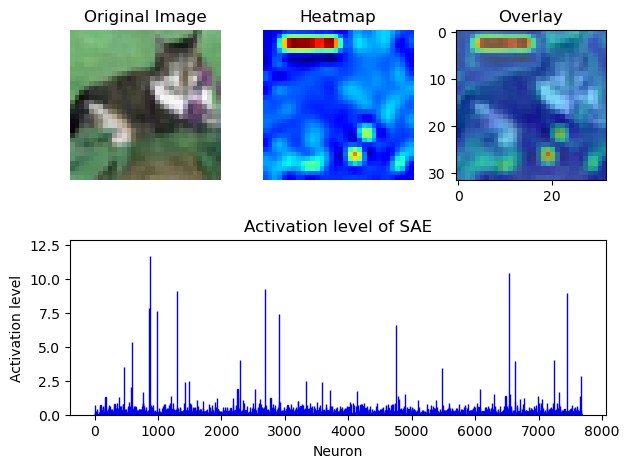

layer 8


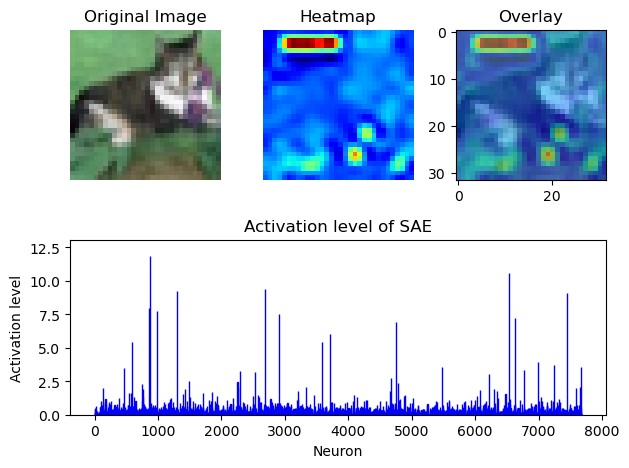

layer 9


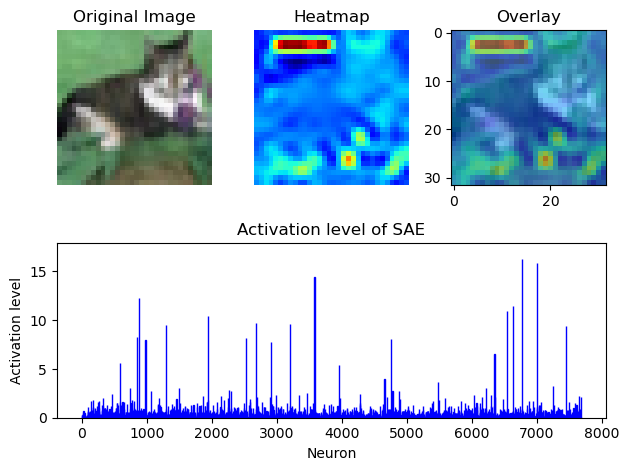

layer 10


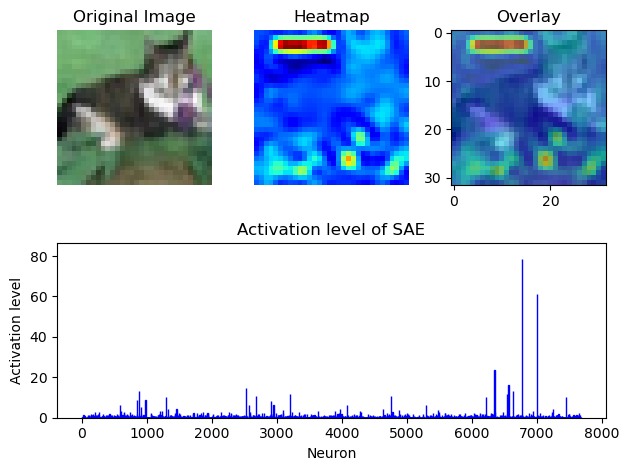

layer 11


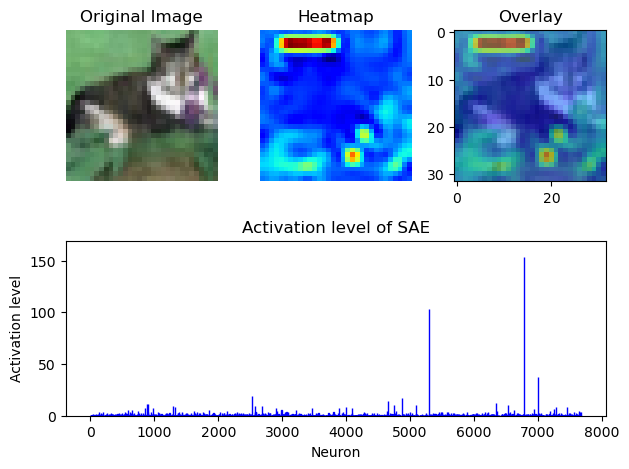

In [6]:
#run for all layers model ratio 10
for i in range(12):
    print(f'layer {i}')
    plot_activation('nateraw/vit-base-patch16-224-cifar10','SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',input_image,layer_number = i, ratio=10, device= device)

for i in range(12):
    print(f'layer {i}')
    plot_activation('nateraw/vit-base-patch16-224-cifar10','SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',input_image2,layer_number = i, ratio=10, device=device)

for i in range(12):
    print(f'layer {i}')
    plot_activation('nateraw/vit-base-patch16-224-cifar10','SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',input_image3,layer_number = i, ratio=10, device=device)

## Look into layer 5 activations 

In [29]:
#layer5 most activated neuron
input_image = transforms.ToPILImage()(input_image)
input_image2 = transforms.ToPILImage()(input_image2)
input_image3 = transforms.ToPILImage()(input_image3)
input1 = processor(images=input_image, return_tensors="pt")
input2 = processor(images=input_image2, return_tensors="pt")
input3 = processor(images=input_image3, return_tensors="pt")

input1.to(device)
input2.to(device)
input3.to(device)

activation_input1 = model(**input1)['hidden_states'][6]
activation_input2 = model(**input2)['hidden_states'][6]
activation_input3 = model(**input3)['hidden_states'][6]

# initiate the encoder and encoder_bias for SAE
encoder = torch.randn((7680, 768)) # encoder
nn.init.xavier_uniform_(encoder)
encoder_bias = torch.zeros(7680) # encoder bias

# Create a SAE instance
tied_sae = TiedSAE(encoder, encoder_bias)
tied_sae.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth'))
tied_sae.to_device(device)

# Calculate the activation levels for the input patch
activation1 = tied_sae.encode(activation_input1).squeeze(0)
activation2 = tied_sae.encode(activation_input2).squeeze(0)
activation3 = tied_sae.encode(activation_input3).squeeze(0)

In [30]:
top_features_values1, top_features_indices1 = torch.topk(activation1.mean(dim=0), k=10, largest=True)
top_features_values2, top_features_indices2 = torch.topk(activation2.mean(dim=0), k=10, largest=True)
top_features_values3, top_features_indices3 = torch.topk(activation3.mean(dim=0), k=10, largest=True)
print(top_features_indices1)
print(top_features_indices2)
print(top_features_indices3)

tensor([ 880, 6535, 2684, 1298, 7454,  851,  977, 2903, 4753,  589],
       device='cuda:0')
tensor([ 880, 4753, 6535, 2684, 1298, 7454,  851,  977, 2903,  589],
       device='cuda:0')
tensor([ 880, 4753, 6535, 2684, 1298, 7454,  851,  977, 2903, 4137],
       device='cuda:0')


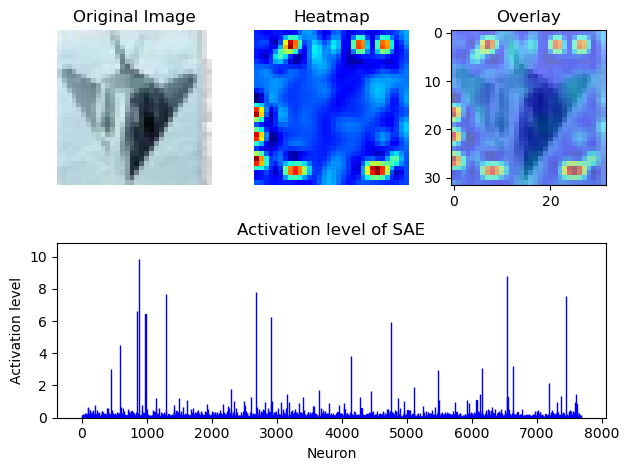

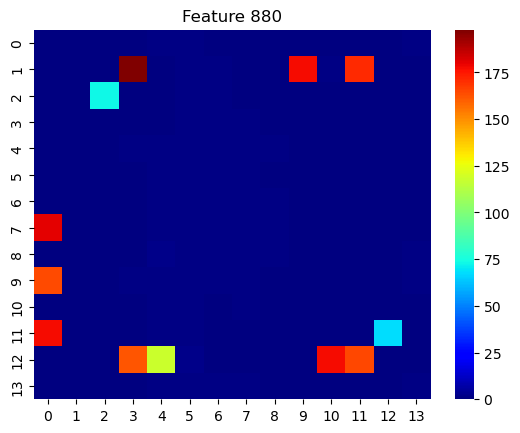

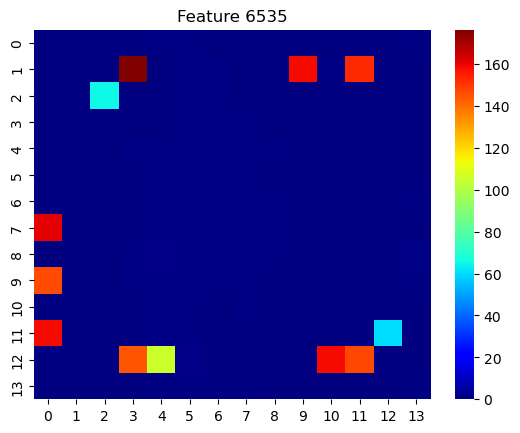

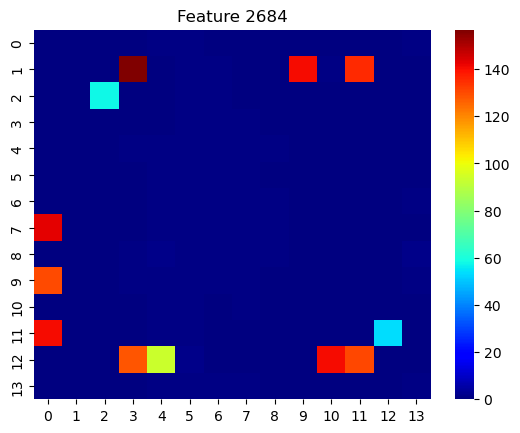

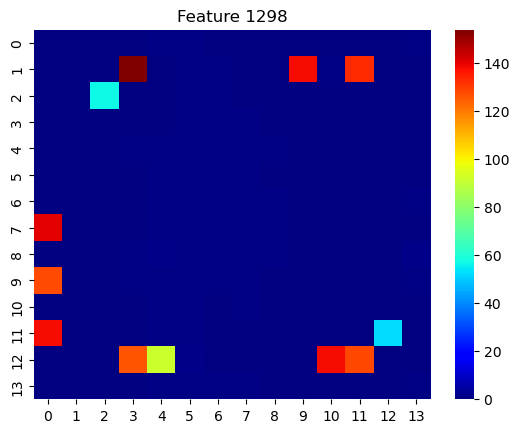

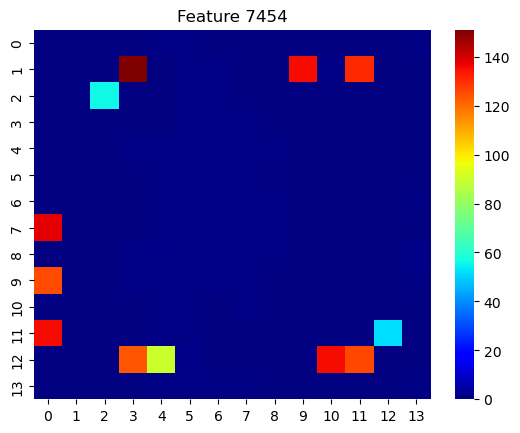

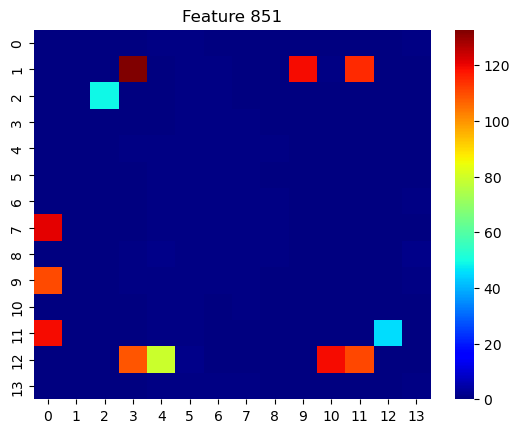

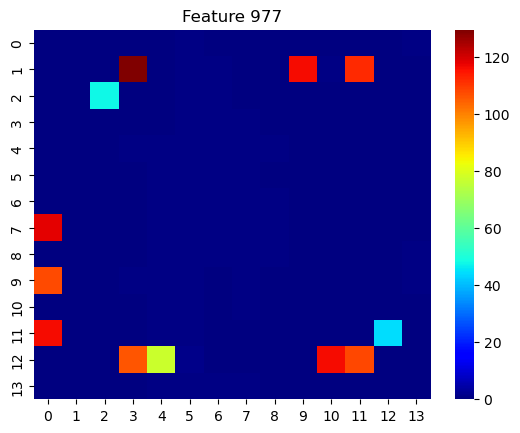

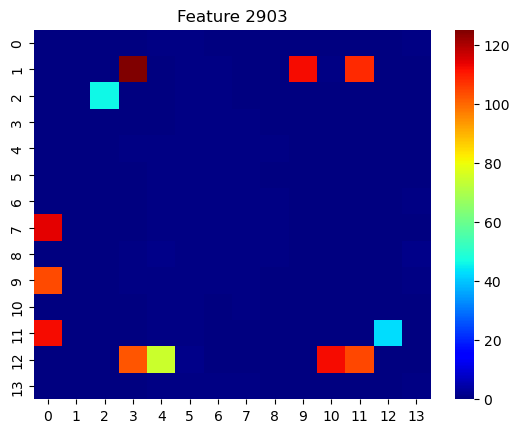

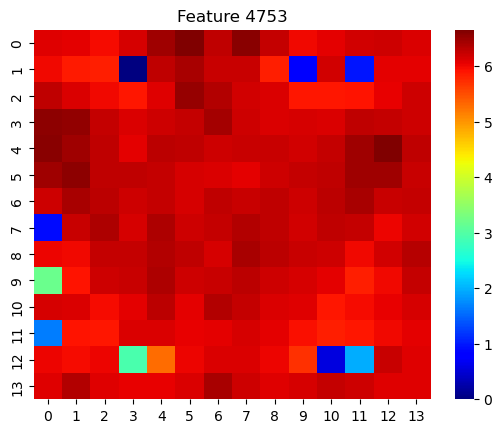

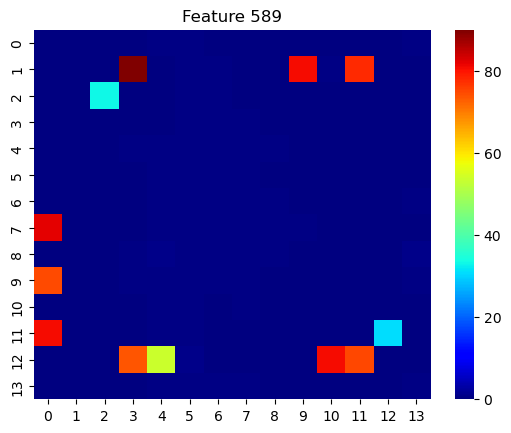

In [31]:
# plot activation of layer of study  
plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',input_image,layer_number = 5, ratio=10, device= device)

# patches where the most activated feature is located

for i in range(10):
    # Select the activations
    selected_activations = activation1[:, top_features_indices1[i]][1:]

    # Reshape the activations into a 14x14 matrix
    heatmap_data = selected_activations.reshape(14, 14)

    # Plot the heatmap
    sns.heatmap(heatmap_data.cpu().detach().numpy(), cmap='jet')
    plt.title(f'Feature {top_features_indices1[i]}')
    plt.show()


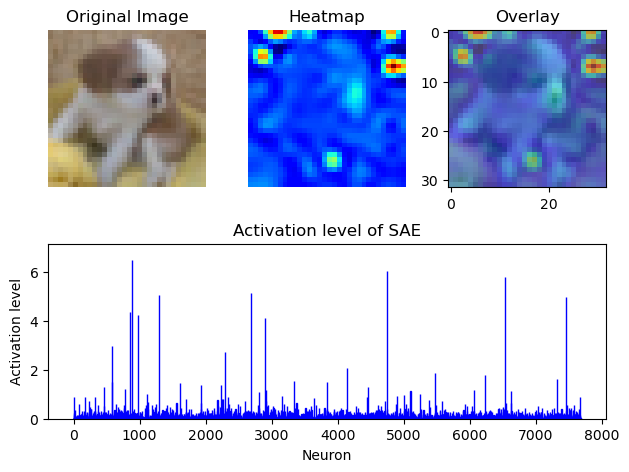

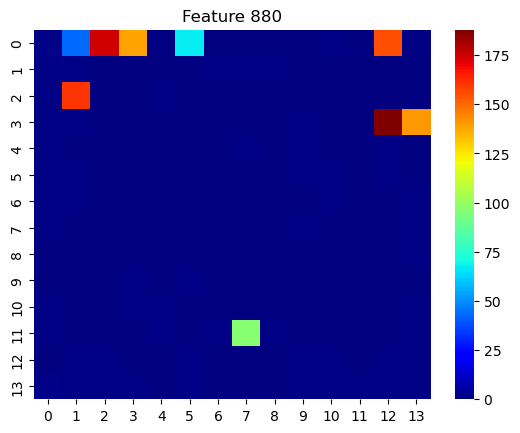

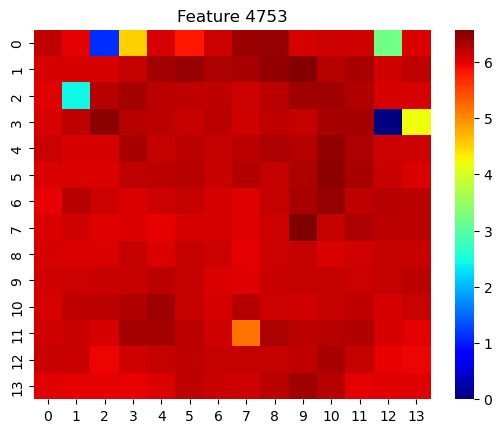

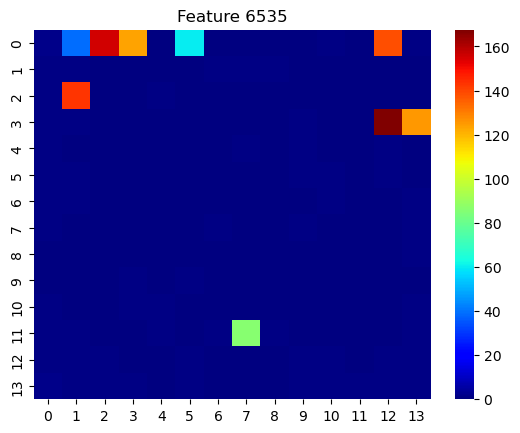

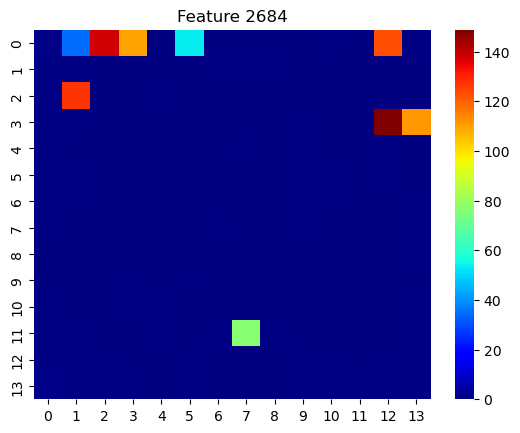

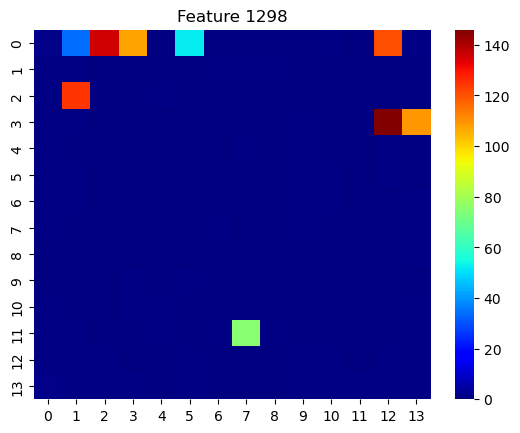

In [10]:
# plot activation of layer of study  
plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',input_image2,layer_number = 5, ratio=10, device= device)

# patches where the most activated feature is located

for i in range(5):
    # Select the activations
    selected_activations = activation2[:, top_features_indices2[i]][1:]

    # Reshape the activations into a 14x14 matrix
    heatmap_data = selected_activations.reshape(14, 14)

    # Plot the heatmap
    sns.heatmap(heatmap_data.cpu().detach().numpy(), cmap='jet')
    plt.title(f'Feature {top_features_indices2[i]}')
    plt.show()


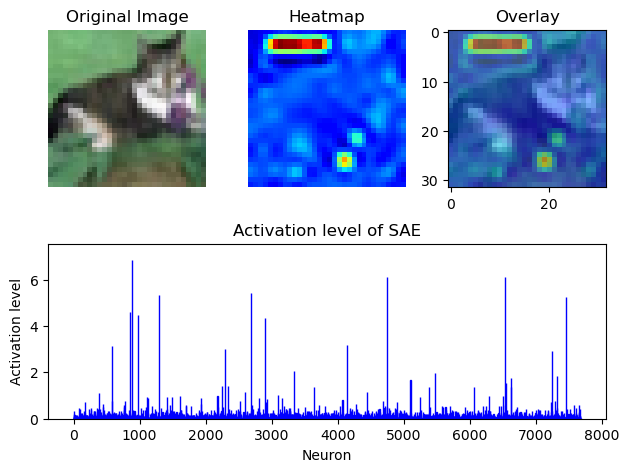

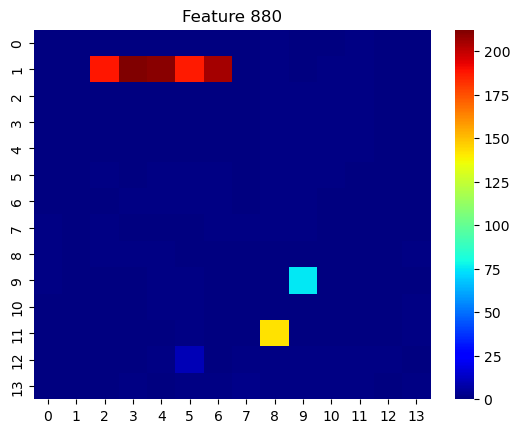

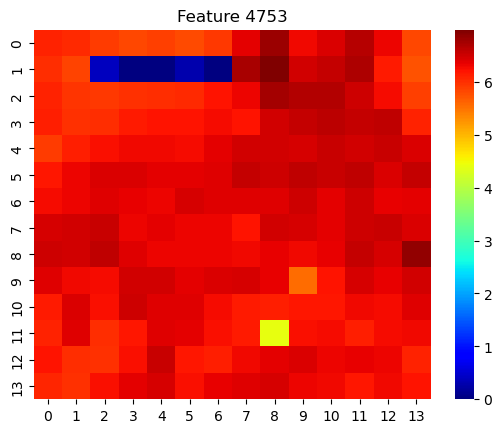

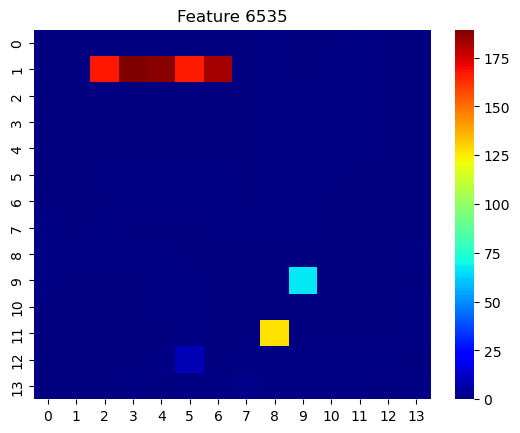

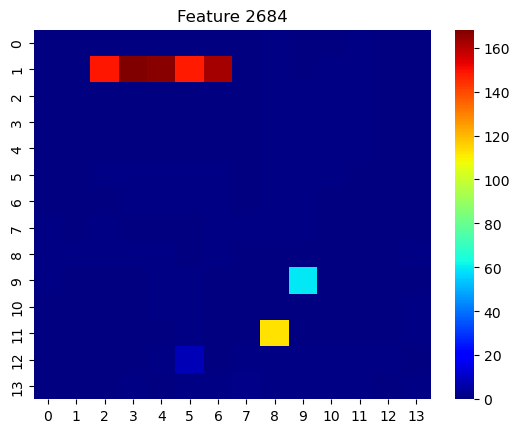

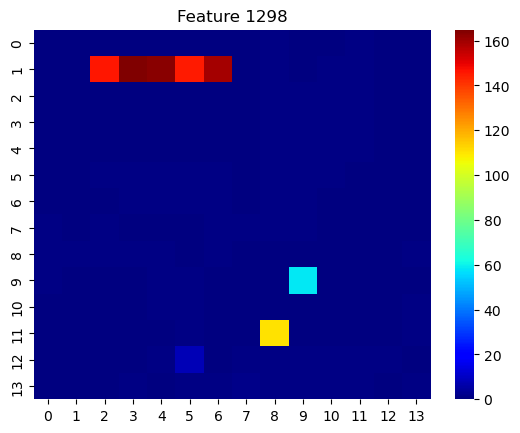

In [11]:
# plot activation of layer of study  
plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',input_image3,layer_number = 5, ratio=10, device= device)

# patches where the most activated feature is located

for i in range(5):
    # Select the activations
    selected_activations = activation3[:, top_features_indices3[i]][1:]

    # Reshape the activations into a 14x14 matrix
    heatmap_data = selected_activations.reshape(14, 14)

    # Plot the heatmap
    sns.heatmap(heatmap_data.cpu().detach().numpy(), cmap='jet')
    plt.title(f'Feature {top_features_indices3[i]}')
    plt.show()


## Look into layer 0 activations

In [12]:
#layer 0 most activated neuron

activation_input1 = model(**input1)['hidden_states'][1]
activation_input2 = model(**input2)['hidden_states'][1]
activation_input3 = model(**input3)['hidden_states'][1]

# initiate the encoder and encoder_bias for SAE
encoder = torch.randn((7680, 768)) # encoder
nn.init.xavier_uniform_(encoder)
encoder_bias = torch.zeros(7680) # encoder bias

# Create a SAE instance
tied_sae = TiedSAE(encoder, encoder_bias)
tied_sae.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth'))
tied_sae.to_device(device)

# Calculate the activation levels for the input patch
activation1 = tied_sae.encode(activation_input1).squeeze(0)
activation2 = tied_sae.encode(activation_input2).squeeze(0)
activation3 = tied_sae.encode(activation_input3).squeeze(0)

In [13]:
top_features_values1, top_features_indices1 = torch.topk(activation1.mean(dim=0), k=10, largest=True)
top_features_values2, top_features_indices2 = torch.topk(activation2.mean(dim=0), k=10, largest=True)
top_features_values3, top_features_indices3 = torch.topk(activation3.mean(dim=0), k=10, largest=True)
print(top_features_indices1)
print(top_features_indices2)
print(top_features_indices3)

tensor([4753, 1705, 2924, 2731, 1145,  880, 3711, 6535, 5735, 6548],
       device='cuda:0')
tensor([4753,  880, 6535, 2684, 1298, 2731, 7454, 1107,  851,  779],
       device='cuda:0')
tensor([4753, 6508, 6548,  880, 7471, 6535, 3056, 2329,  366, 2684],
       device='cuda:0')


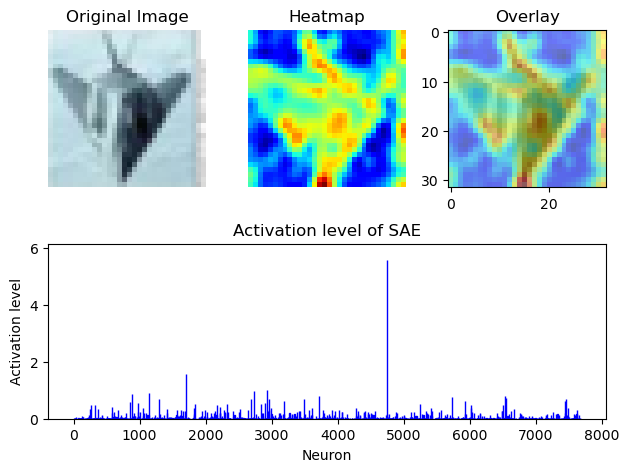

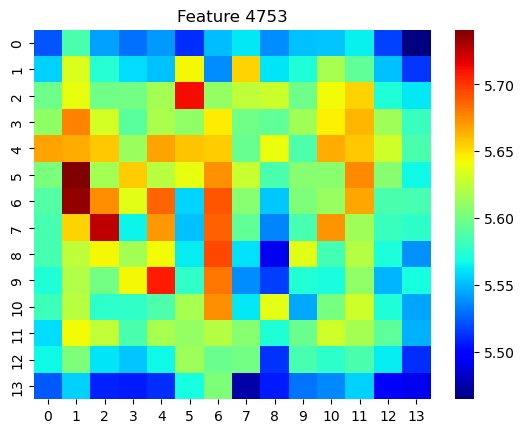

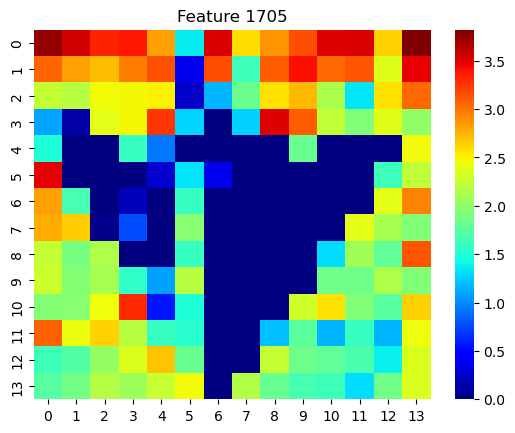

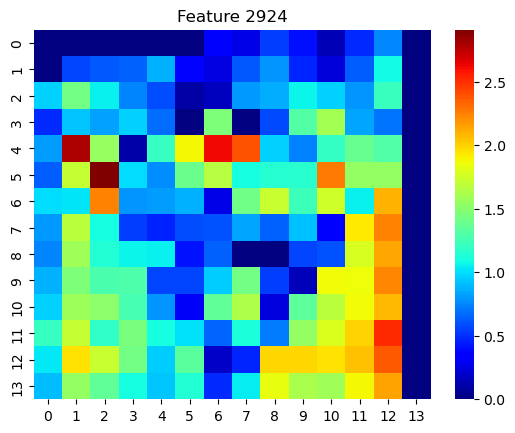

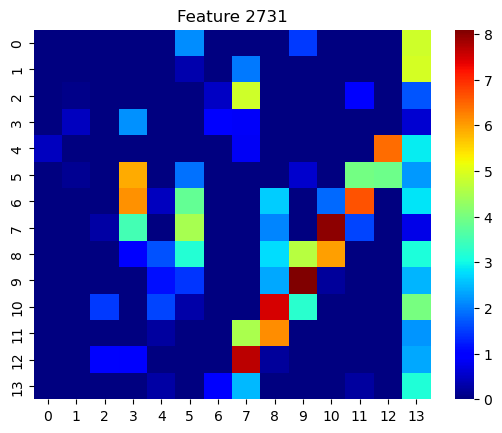

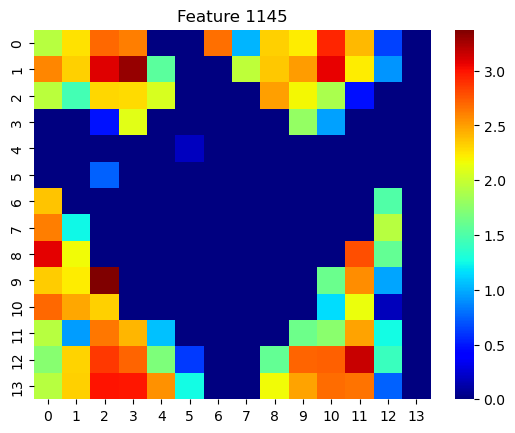

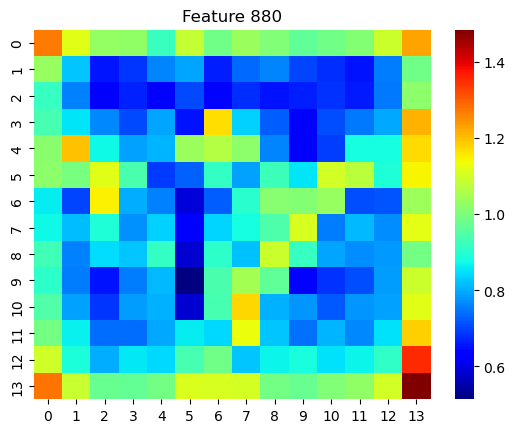

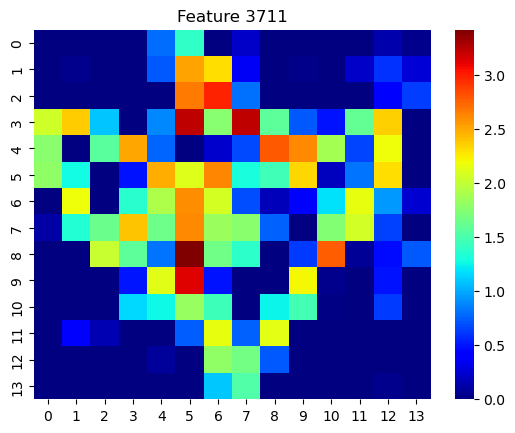

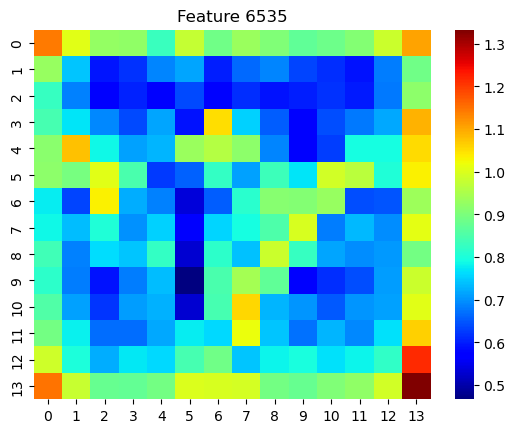

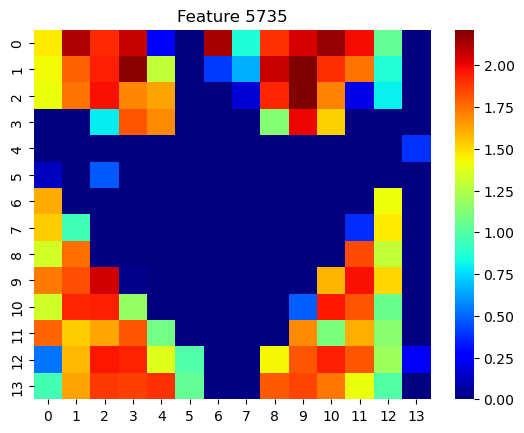

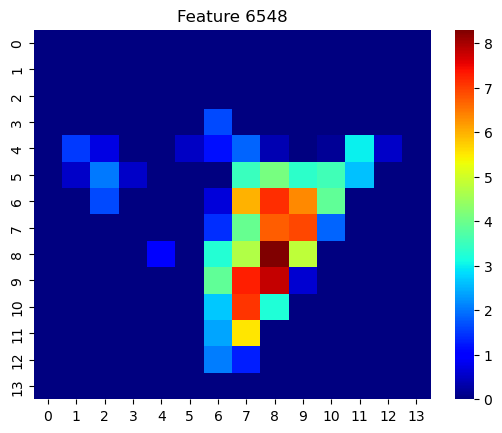

In [26]:
# plot activation of layer of study  
plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',input_image,layer_number = 0, ratio=10, device= device)

# patches where the most activated feature is located

for i in range(10):
    # Select the activations
    selected_activations = activation1[:, top_features_indices1[i]][1:]

    # Reshape the activations into a 14x14 matrix
    heatmap_data = selected_activations.reshape(14, 14)

    # Plot the heatmap
    sns.heatmap(heatmap_data.cpu().detach().numpy(), cmap='jet')
    plt.title(f'Feature {top_features_indices1[i]}')
    plt.show()


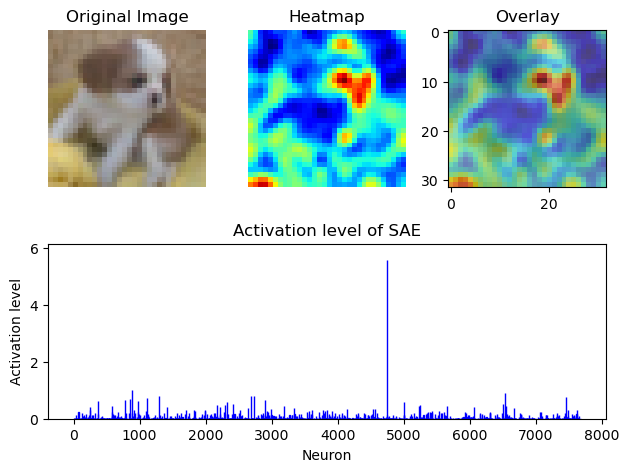

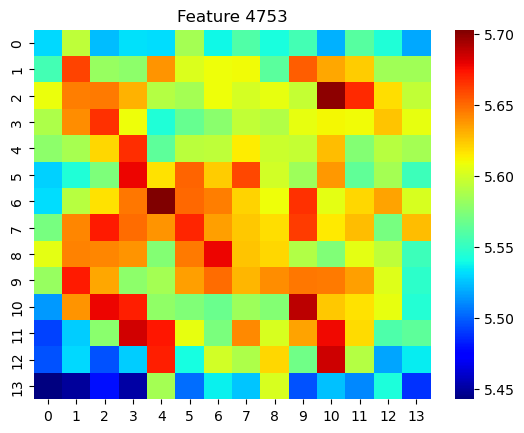

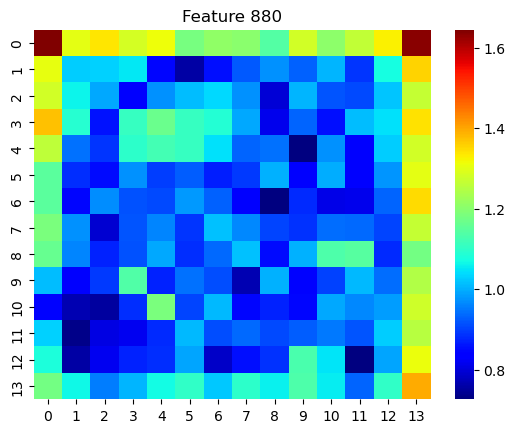

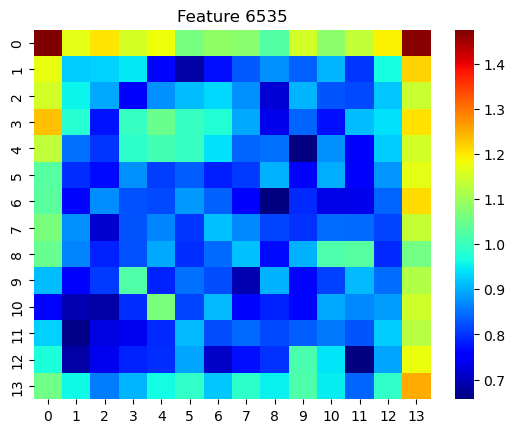

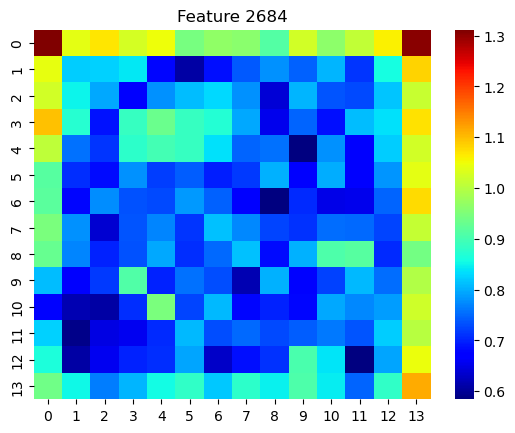

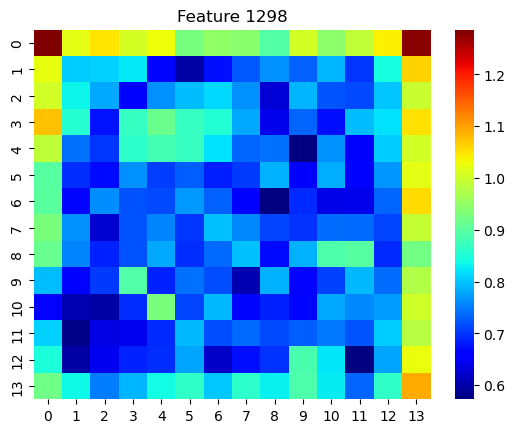

In [15]:
# plot activation of layer of study  
plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',input_image2,layer_number = 0, ratio=10, device= device)

# patches where the most activated feature is located

for i in range(5):
    # Select the activations
    selected_activations = activation2[:, top_features_indices2[i]][1:]

    # Reshape the activations into a 14x14 matrix
    heatmap_data = selected_activations.reshape(14, 14)

    # Plot the heatmap
    sns.heatmap(heatmap_data.cpu().detach().numpy(), cmap='jet')
    plt.title(f'Feature {top_features_indices2[i]}')
    plt.show()


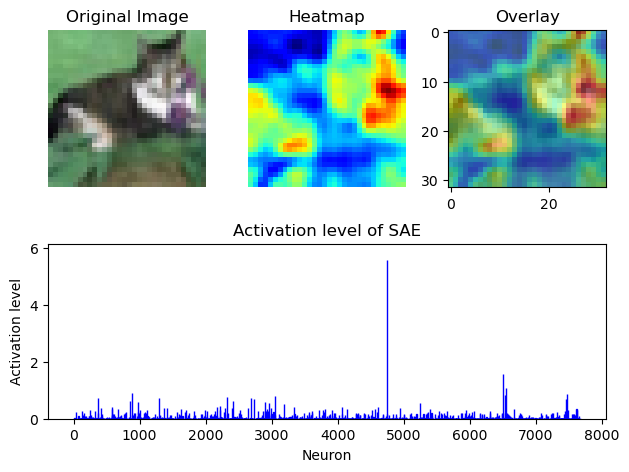

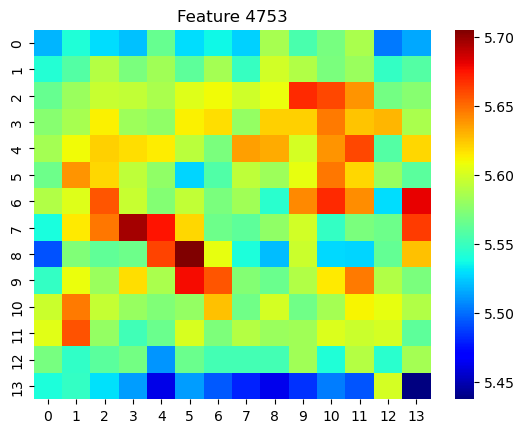

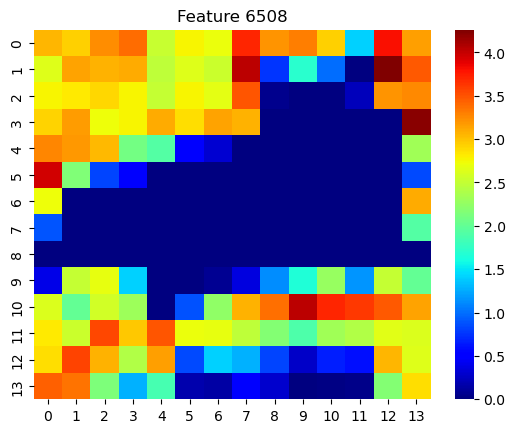

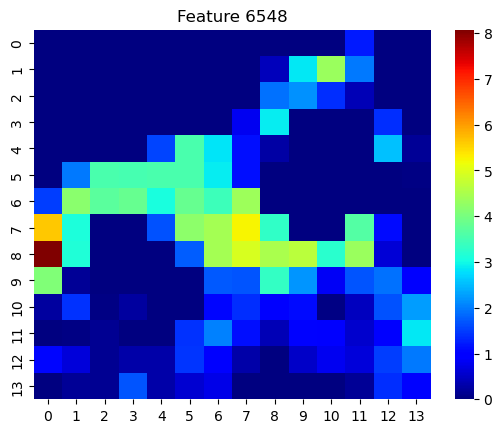

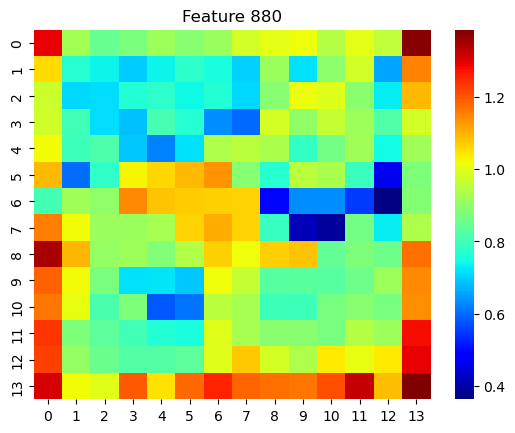

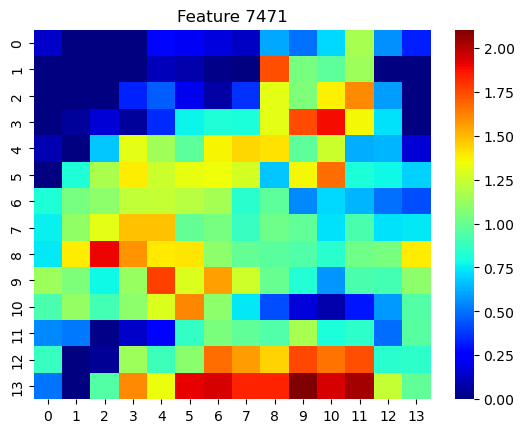

In [16]:
# plot activation of layer of study  
plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',input_image3,layer_number = 0, ratio=10, device= device)

# patches where the most activated feature is located

for i in range(5):
    # Select the activations
    selected_activations = activation3[:, top_features_indices3[i]][1:]

    # Reshape the activations into a 14x14 matrix
    heatmap_data = selected_activations.reshape(14, 14)

    # Plot the heatmap
    sns.heatmap(heatmap_data.cpu().detach().numpy(), cmap='jet')
    plt.title(f'Feature {top_features_indices3[i]}')
    plt.show()


## Look into most activated features in All layers

In [17]:
activation_inputs1 = model(**input1)['hidden_states'][1:]
activation_inputs2 = model(**input2)['hidden_states'][1:]
activation_inputs3 = model(**input3)['hidden_states'][1:]

# initiate the encoder and encoder_bias for SAE
encoder = torch.randn((7680, 768)) # encoder
nn.init.xavier_uniform_(encoder)
encoder_bias = torch.zeros(7680) # encoder bias

# Create a SAE instance
tied_sae = TiedSAE(encoder, encoder_bias)
tied_sae.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth'))
tied_sae.to_device(device)

# Calculate the activation levels for the input patch
activations_1 =[]
activations_2 =[]
activations_3 =[]


for i in range(12):
    activations_1.append(tied_sae.encode(activation_inputs1[i]).squeeze(0))
    activations_2.append(tied_sae.encode(activation_inputs2[i]).squeeze(0))
    activations_3.append(tied_sae.encode(activation_inputs3[i]).squeeze(0))


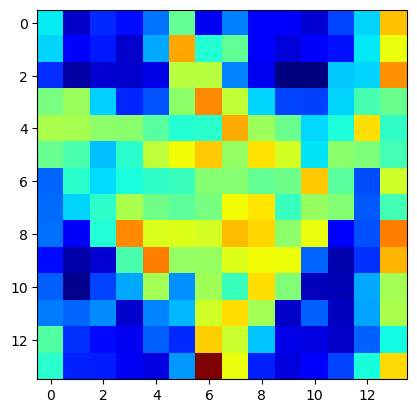

In [18]:
plt.imshow(activations_1[0][1:].mean(dim=1).cpu().detach().numpy().reshape(14,14), cmap='jet')

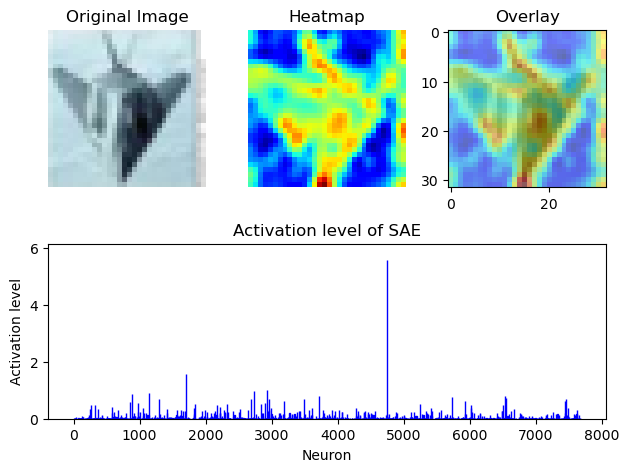

In [19]:
# plot activation of layer of study  
plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth',input_image,layer_number = 0, ratio=10, device= device)


In [20]:
top_features1 = []
top_features2 = []
top_features3 = []
for i in range(12):
    # Detach the tensors before passing them to torch.topk()
    tensor1 = activations_1[i].mean(dim=0).detach().cpu()
    tensor2 = activations_2[i].mean(dim=0).detach().cpu()
    tensor3 = activations_3[i].mean(dim=0).detach().cpu()

    top_features1.append(torch.topk(tensor1, k=10, largest=True).indices)
    top_features2.append(torch.topk(tensor2, k=10, largest=True).indices)
    top_features3.append(torch.topk(tensor3, k=10, largest=True).indices)

In [21]:
print("Image 1")
[print(i) for i in top_features1]

print("Image 2")
[print(i) for i in top_features2]

print("Image 3")
[print(i) for i in top_features3]

Image 1
tensor([4753, 1705, 2924, 2731, 1145,  880, 3711, 6535, 5735, 6548])
tensor([4753, 1705, 2924, 5931, 3711, 5735, 5245, 6548, 1415, 2731])
tensor([4753, 1705, 2924, 5931, 6548, 5245, 5735, 1415, 3711, 2291])
tensor([4753,    9, 5931, 4279, 5245, 2291, 2164, 5735, 2924, 6548])
tensor([4753, 4137,  880, 6535, 6157, 2684, 1298, 7454, 6628,  851])
tensor([ 880, 6535, 2684, 1298, 7454,  851,  977, 2903, 4753,  589])
tensor([ 880, 6535, 2684, 1298, 7454,  851,  977, 2903,  589, 4753])
tensor([ 880, 6535, 2684, 1298, 7454,  851,  977, 2903,  589, 4753])
tensor([ 880, 6535, 2684, 1298, 7454,  851,  977, 2903, 7613,  589])
tensor([7613,  880, 4775, 6535, 5533, 2684, 1298, 1342, 5115, 7454])
tensor([4775, 5115, 7613, 5703, 3961, 1896, 6348, 6218,  880, 2700])
tensor([5115, 4775, 1896, 2700, 7613,  880, 2913, 6535, 3140, 6218])
Image 2
tensor([4753,  880, 6535, 2684, 1298, 2731, 7454, 1107,  851,  779])
tensor([4753,  779, 1107, 5245, 5011,  880, 2291, 6508, 6535, 1415])
tensor([4753, 2291

[None, None, None, None, None, None, None, None, None, None, None, None]

In [22]:
# extract top 10 features that activated in a input across all layers
def get_top_indices(top_features, num_top=10):
    tops = []
    for i in top_features:
        tops.append(i.cpu().detach().numpy())
    tops = np.concatenate(tops)

    # Count the occurrences of each value
    value_counts = Counter(tops)

    # Create a dictionary with value and counts
    value_counts_dict = dict(value_counts)
    sorted_counts = sorted(value_counts_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_indices = [index for index, _ in sorted_counts[:num_top]]
    
    return sorted_indices

In [23]:
top_indices1 = get_top_indices(top_features1)
top_indices2 = get_top_indices(top_features2)
top_indices3 = get_top_indices(top_features3)

print(top_indices1)
print(top_indices2)
print(top_indices3)

[880, 4753, 6535, 2684, 1298, 7454, 851, 2924, 5735, 6548]
[4753, 880, 6535, 2684, 1298, 7454, 851, 779, 1107, 2291]
[880, 4753, 6535, 2684, 1298, 7454, 851, 6508, 6548, 7249]


## create heatmaps for most activated neurons in each layer

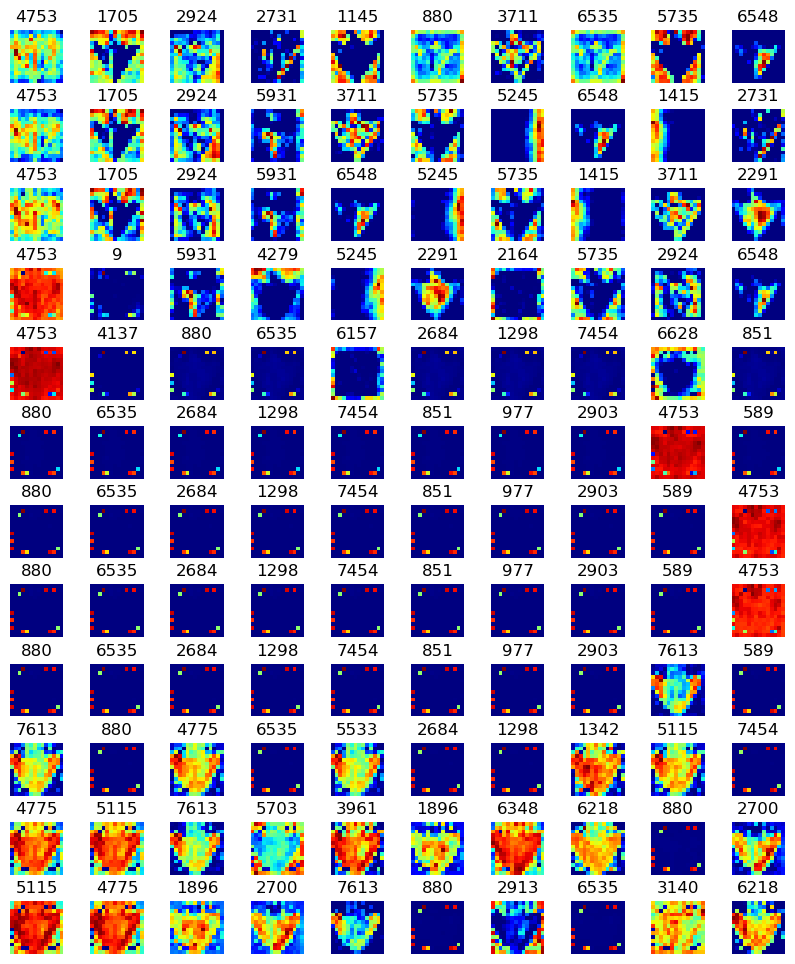

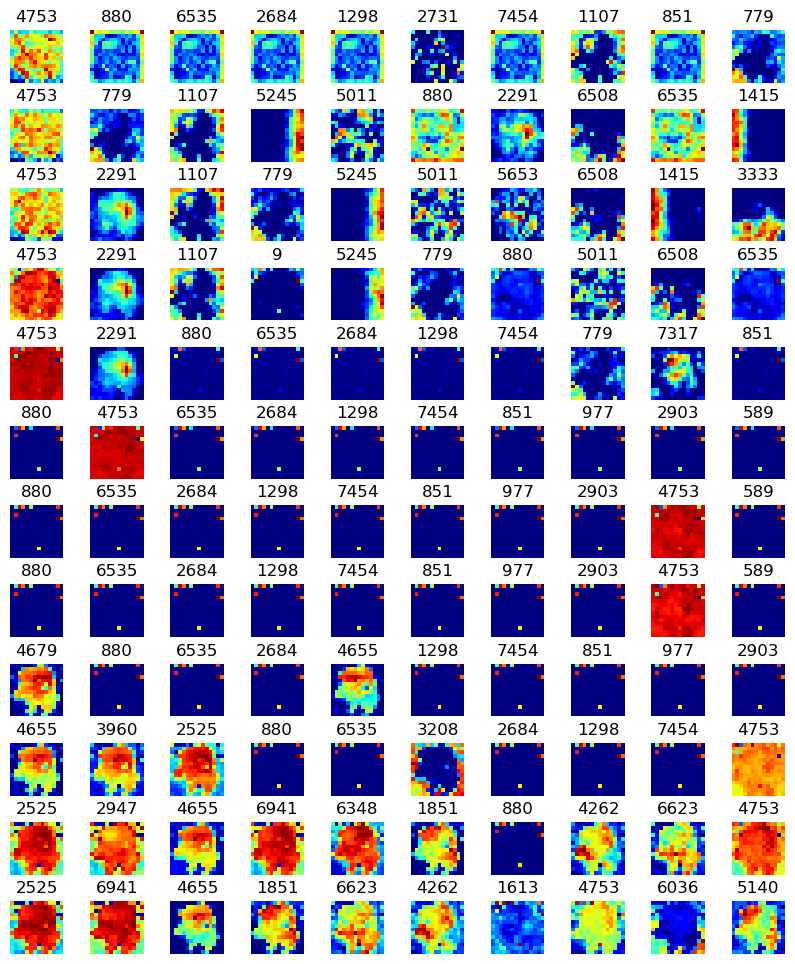

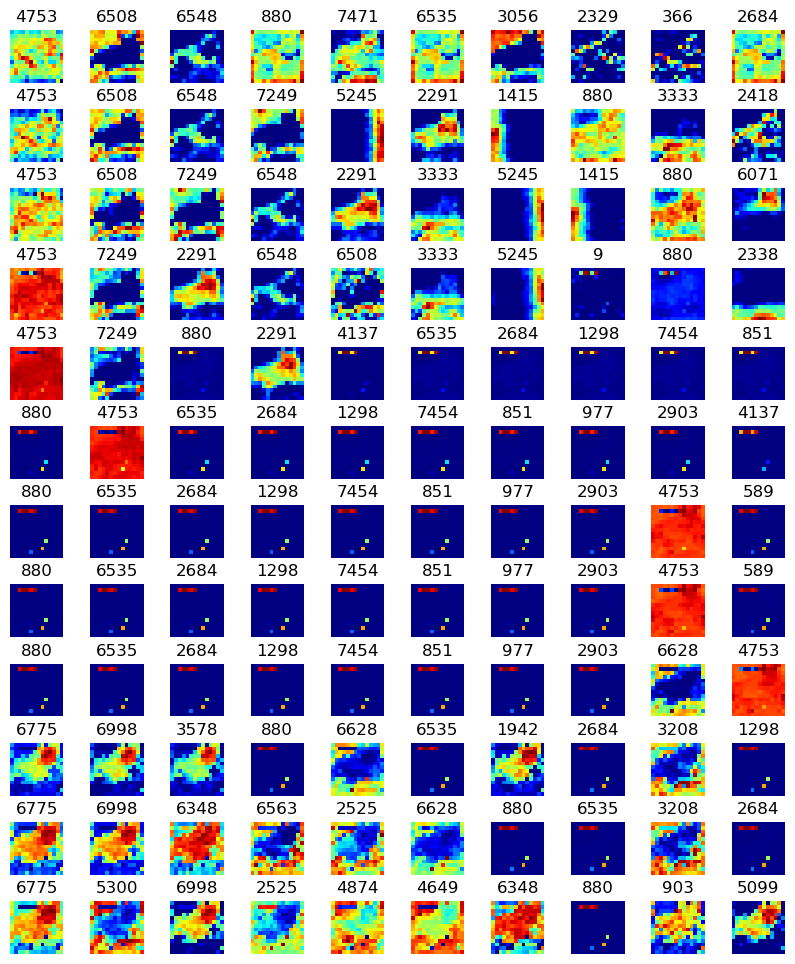

In [25]:
# Define a function to create a heatmap
def create_heatmap(activations, top_features):
    fig, axs = plt.subplots(12, 10, figsize=(10, 12))
    for i, layer_features in enumerate(top_features):
        for j, feature in enumerate(layer_features):
            ax = axs[i, j]
            sns.heatmap(activations[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
            ax.set_title(f'{feature}')
            ax.axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
    plt.show()

# Call the function for each image
create_heatmap(activations_1, top_features1)
create_heatmap(activations_2, top_features2)
create_heatmap(activations_3, top_features3)